## All-sky electron density maps

[Healpix](https://healpix.jpl.nasa.gov/) (Hierarchical Equal Area isoLatitude Pixelization) is a scheme for dealing with all-sky data. 

We can use the Python [healpy](https://healpy.readthedocs.io/en/latest/tutorial.html) bindings together with `pygedm` to generate all-sky maps of the Galactic electron density.

#### Import and setup

In [12]:
%matplotlib inline

In [50]:
import healpy as hp
import numpy as np
import pygedm
import pylab as plt
from astropy import units as u
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

First, we need to generate a list of galactic coordinates corresponding to pixel coordinates in a healpy image. 

In [47]:
NSIDE = 128                                        # Resolution of the healpix map
print("NSIDE: {} NPIXELS: {}".format(NSIDE, hp.nside2npix(NSIDE)))

pix_id = np.arange(hp.nside2npix(NSIDE))           # Generate pixel IDs
gl, gb = hp.pix2ang(NSIDE, pix_id, lonlat=True)    # Compute galactic coordinates for all pixels

# Create empty arrays for NE2001 and YMW16 data
d_2001 = np.zeros_like(pix_id, dtype='float32')
d_2016 = np.zeros_like(pix_id, dtype='float32')

NSIDE: 128 NPIXELS: 196608


Now, to generate the maps we evaluate the EDMs for a given distance for each pixel.

To generate the full Galactic contribution to DM, we can simply compute out to 30 kpc for both models.

In [49]:
distance = 30000 * u.pc

for ii in pix_id:
    dm_2016, tau_2016 = pygedm.dist_to_dm(gl[ii], gb[ii], distance, method='ymw16')
    dm_2001, tau_2001 = pygedm.dist_to_dm(gl[ii], gb[ii], distance, method='ne2001')
    d_2001[ii] = dm_2001.value
    d_2016[ii] = dm_2016.value

We can then plot the models using `hp.mollview`, and compare the two.

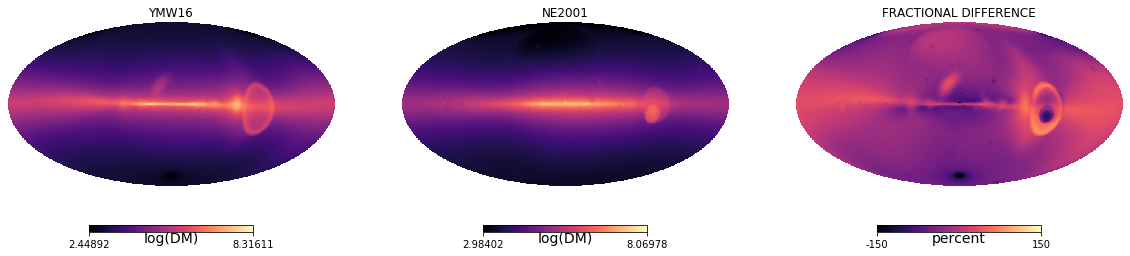

In [51]:
plt.figure(figsize=(20, 14))
plt.subplot(1,3,1)
hp.mollview(np.log(d_2016), title='YMW16', cmap='magma', unit='log(DM)', hold=True)
plt.subplot(1,3,2)
hp.mollview(np.log(d_2001), title='NE2001', cmap='magma', unit='log(DM)',  hold=True)
plt.subplot(1,3,3)
hp.mollview((d_2016 - d_2001)/ d_2016 * 100, min=-150, max=150,
            title='FRACTIONAL DIFFERENCE', unit='percent', cmap='magma', hold=True)

A variety of structures are apparent in the all-sky images, notably the Galactic disk (modelled as a thin and thick component in both), galactic centre, and 'bubbles' due to the Gum Nebula. The North Polar Spur is visible in the YMW16 model, but not the NE2001. 

In the fractional map, we see that there are areas where the models diverge. NE2001 is known to underpredict several high-latitude pulsars, and overprict several local pulsars.  We can also see small areas where NE2001 opted to model a 'clump' or 'void', an approach which YMW16 argues against.

We can take a closer look at the overall difference between the two models:

Average difference: -15.18 +/- 28.95 %


Text(0, 0.5, 'Pixel Count (normalized)')

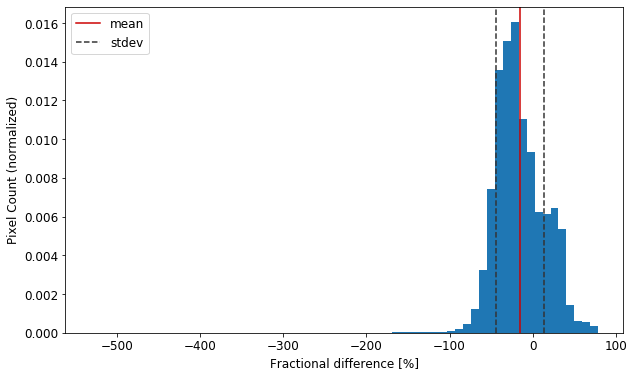

In [82]:
frac_diff = (d_2016 - d_2001)/ d_2016 * 100
avg_diff  = np.mean(frac_diff)
std_diff  = np.std(frac_diff)

print("Average difference: {:2.2f} +/- {:2.2f} %".format(avg_diff, std_diff))

plt.rcParams['font.size'] = 12
plt.figure(figsize=(10, 6))
cb = plt.hist(frac_diff, 64, normed=True)
plt.axvline(x=avg_diff, c='#cc0000')
plt.axvline(x=avg_diff-std_diff, c='#333333', ls='dashed')
plt.axvline(x=avg_diff+std_diff, c='#333333', ls='dashed')
plt.legend(['mean', 'stdev'])
plt.xlabel("Fractional difference [%]")
plt.ylabel("Pixel Count (normalized)")

That is, the NE2001 is on average 15 percent higher than the YMW16 model, and most pixels (one stdev, 68%) agree to within +/- 29 percent. 

### Largest differences between models

Now we have these integrated maps of DM, we can also look for the most discrepant pixels:

357.890625 9.896853442815882
262.96875 -25.61308321640182
Largest -ve fractional difference:
GLAT, GLON  (357.89, 9.90) deg
NE2001 951.47 pc / cm3 4.00e+04 s
YMW16  150.73 pc / cm3 1.14e-04 s

Largest +ve fractional difference:
GLAT, GLON  (262.97, -25.61) deg
NE2001 62.23 pc / cm3 8.62e-05 s
YMW16  290.34 pc / cm3 1.77e-03 s
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


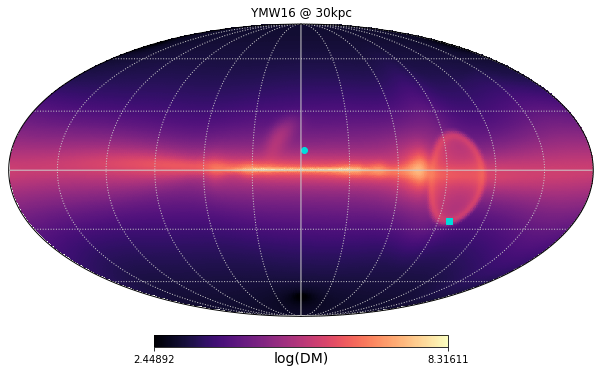

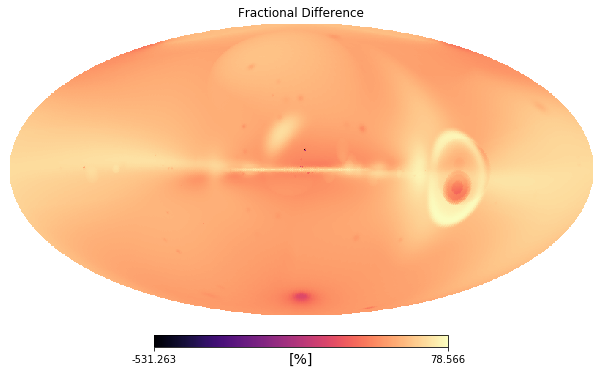

In [148]:
worst_pixel_min = np.argmin(frac_diff)
print(gl[worst_pixel_min], gb[worst_pixel_min])

worst_pixel_max = np.argmax(frac_diff)
print(gl[worst_pixel_max], gb[worst_pixel_max])

gl_wmin, gl_wmax = gl[worst_pixel_min], gl[worst_pixel_max]
gb_wmin, gb_wmax = gb[worst_pixel_min], gb[worst_pixel_max]

print("Largest -ve fractional difference:")
print("GLAT, GLON  ({:2.2f}, {:.2f}) deg".format(gl_wmin, gb_wmin))
print("NE2001 {:.2f} {:.2e}".format(*pygedm.dist_to_dm(gl_wmin, gb_wmin, distance, method='ne2001')))
print("YMW16  {:.2f} {:.2e}".format(*pygedm.dist_to_dm(gl_wmin, gb_wmin, distance,  method='ymw16')))

print("\nLargest +ve fractional difference:")
print("GLAT, GLON  ({:2.2f}, {:.2f}) deg".format(gl_wmax, gb_wmax))
print("NE2001 {:.2f} {:.2e}".format(*pygedm.dist_to_dm(gl_wmax, gb_wmax, distance, method='ne2001')))
print("YMW16  {:.2f} {:.2e}".format(*pygedm.dist_to_dm(gl_wmax, gb_wmax, distance,  method='ymw16')))

hp.mollview(np.log(z_2016), title='YMW16 @ 30kpc', unit='log(DM)', cmap='magma')
hp.visufunc.graticule(color='#cccccc')
hp.visufunc.projscatter(gl[worst_pixel_min], gb[worst_pixel_min], marker='o', color='#00DDDD', lonlat=True)
hp.visufunc.projscatter(gl[worst_pixel_max], gb[worst_pixel_max], marker='s', color='#00DDDD', lonlat=True)

hp.mollview(frac_diff, title='Fractional Difference', unit='[%]', cmap='magma')

We see NE2001 >> YMW16 for an odd pixel tens of degrees above the galactic centre, and YMW16 >> NE2001 on the edge of the bubble feature.

Let's investigate that pixel in NE2001 that seems to be 'bad' -- it's actually a clump 'feature' of NE2001. We can evaluate as a function of distance:

In [193]:
dists = np.arange(10, 25e3, 100) * u.pc
offset = 1.0

dms_2001   = np.zeros(len(dists))
dms_2016   = np.zeros(len(dists))

for ii, d in enumerate(dists):
    dm, tau = pygedm.dist_to_dm(gl_wmin, gb_wmin, d, method='ne2001')
    dms_2001[ii] = dm.value

    dm, tau = pygedm.dist_to_dm(gl_wmin, gb_wmin, d, method='ymw16')
    dms_2016[ii] = dm.value

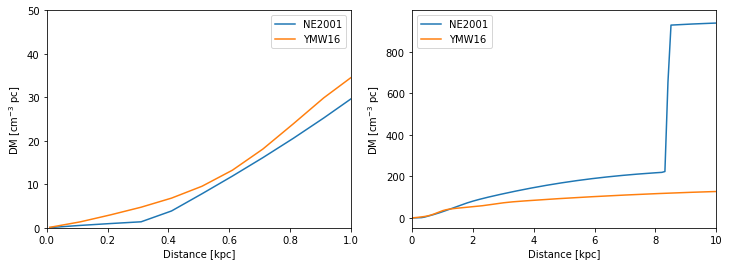

In [217]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(dists/1e3, dms_2001, label='NE2001')
plt.plot(dists/1e3, dms_2016, label='YMW16')
plt.xlim(0, 1)
plt.ylim(0, 50)
plt.xlabel("Distance [kpc]")
plt.ylabel("DM [cm$^{-3}$ pc]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(dists/1e3, dms_2001, label='NE2001')
plt.plot(dists/1e3, dms_2016, label='YMW16')
plt.xlabel("Distance [kpc]")
plt.ylabel("DM [cm$^{-3}$ pc]")
plt.xlim(0, 10)
plt.legend()

We see that the two models agree pretty well up to 1 kpc, but diverge rapidly at 8.4 kpc. This is actually due to a clump in NE2001. Looking the manuscript at Table 6 (clump parameters for galactic non-pulsar lines of sight), we see an entry for **OH357.849**, which adds 866 pc cm^-3 to the DM at a distance of 8.4 kpc.